In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [67]:

def convert_df(path):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['Datetime'])
    df = df.set_index('date')
    df = df[['Close']]
    return df
path = "../data/data/data_daily.csv"
df = convert_df(path)
df.head()

,Close
date,
2007-09-17 00:00:00+00:00,4494.649902
2007-09-18 00:00:00+00:00,4546.200195
2007-09-19 00:00:00+00:00,4732.350098
2007-09-20 00:00:00+00:00,4747.549805
2007-09-21 00:00:00+00:00,4837.549805


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4198 entries, 2007-09-17 00:00:00+00:00 to 2024-10-31 00:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4198 non-null   float64
dtypes: float64(1)
memory usage: 65.6 KB


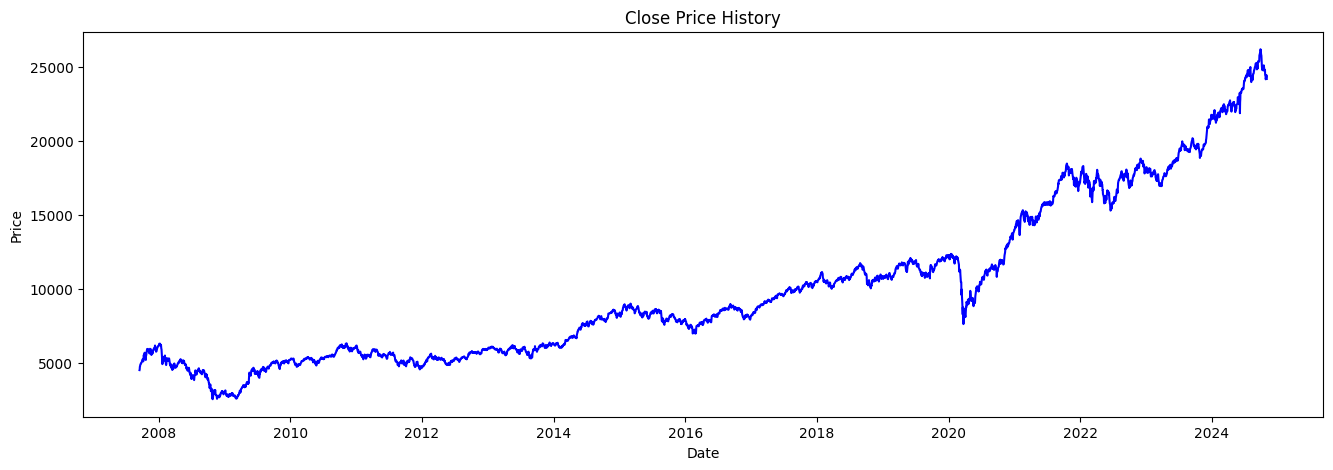

In [71]:
# plot 
def plot_df(df, title="Close Price History"):
    plt.figure(figsize=(16,5))
    plt.plot(df, color='blue', label='Close')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()
plot_df(df)

In [70]:
def Stationarity_Test(df):
    # Dickey-Fuller test
    # df_name = df.columns[0]
    # if df is series
    if isinstance(df, pd.Series):
        result = adfuller(df.values, autolag='AIC')
    else:
        result = adfuller(df.values, autolag='AIC')
    print(f'The series is', 'not stationary.' if result[1] > 0.05 else 'stationary.')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
Stationarity_Test(df)

The series is not stationary.
ADF Statistic: 1.697346
p-value: 0.998122


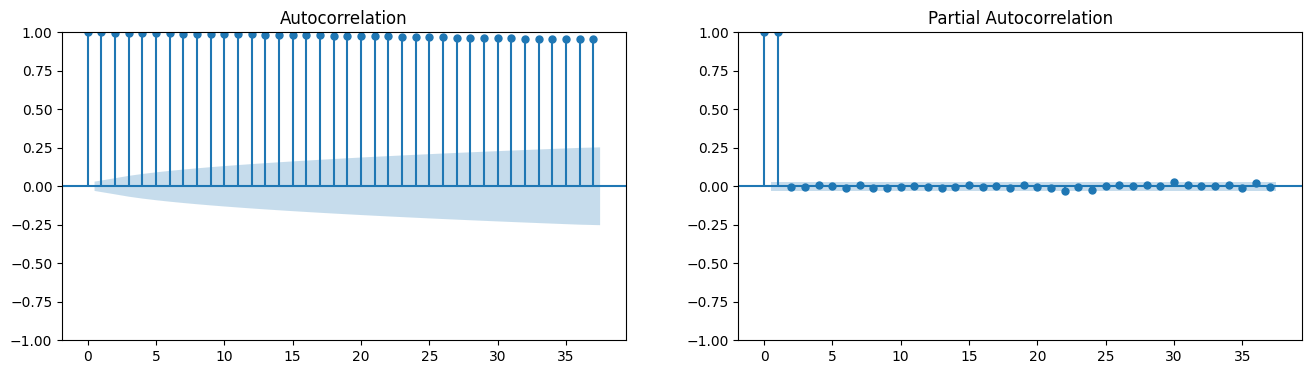

In [72]:
def plot_acf_pacf(df):
    fig, ax = plt.subplots(1,2,figsize=(16,4))
    plot_acf(df, ax=ax[0])
    plot_pacf(df, ax=ax[1])
    plt.show()
plot_acf_pacf(df)

To make non-stationary data stationary, there are several common transformations you can try, each addressing different aspects of non-stationarity. Here’s a list of approaches:

1. **Differencing**: Subtract each data point from the previous one to remove trends.
   - **First-order differencing**: $Y_t - Y_{t-1} $
   - **Second-order differencing**: $(Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2}) $

2. **Log Transformation**: Apply a log function to stabilize variance, particularly helpful with exponential trends.
   - $ Y'_t = \ln(Y_t) $

3. **Square Root Transformation**: Similar to log transformation but less aggressive; used to stabilize variance.
   - $Y'_t = \sqrt{Y_t} $

4. **Power Transformation**: Generalize the log or square root transformations to other exponents.
   - Example: **Box-Cox Transformation**, which includes logarithmic and square root as specific cases and allows optimization of the power parameter \(\lambda$.

5. **Moving Average Smoothing**: Calculate a moving average to smooth out fluctuations, useful for reducing noise and identifying trends.
   - Simple Moving Average: $Y'_t = \frac{Y_{t} + Y_{t-1} + ... + Y_{t-n}}{n+1} $

6. **Exponential Smoothing**: Apply exponential weights to past values to reduce trend effects.
   - Commonly used methods include **Simple Exponential Smoothing (SES)** and **Exponential Moving Average (EMA)**.

7. **Seasonal Differencing**: Subtract the value from the same season in previous periods to remove seasonality.
   - Seasonal Difference: $Y_t - Y_{t-s} $, where \(s$ is the seasonal period (e.g., 12 for monthly data).

Each transformation may be more suitable depending on whether your data shows trends, seasonality, or changing variance. Testing different methods can help you identify the one that best suits your data.

In [73]:

from scipy.stats import boxcox

class Transformation:
    def __init__(self, data):
        self.data = data
        self.transformed_data = None
        self.lmbda = None  # for Box-Cox

    def log_transform(self):
        """Apply log transformation to data."""
        self.transformed_data = np.log(self.data)
        return self.transformed_data

    def log_inverse(self):
        """Inverse log transformation."""
        if self.transformed_data is not None:
            return np.exp(self.transformed_data)
        raise ValueError("No transformed data available. Apply log_transform first.")

    def first_difference(self):
        """Apply first-order differencing to data."""
        self.transformed_data = self.data.diff().dropna()
        return self.transformed_data

    def first_difference_inverse(self):
        """Inverse first-order differencing."""
        if self.transformed_data is not None:
            return self.transformed_data.cumsum() + self.data.iloc[0]
        raise ValueError("No transformed data available. Apply first_difference first.")

    def pct_change(self):
        """Calculate percentage change (returns)."""
        self.transformed_data = self.data.pct_change().dropna()
        return self.transformed_data

    def pct_change_inverse(self):
        """Inverse percentage change transformation."""
        if self.transformed_data is not None:
            return (self.transformed_data + 1).cumprod() * self.data.iloc[0]
        raise ValueError("No transformed data available. Apply pct_change first.")

    def boxcox_transform(self):
        """Apply Box-Cox transformation to data."""
        self.transformed_data, self.lmbda = boxcox(self.data)
        return self.transformed_data

    def boxcox_inverse(self):
        """Inverse Box-Cox transformation."""
        if self.transformed_data is not None and self.lmbda is not None:
            if self.lmbda == 0:
                return np.exp(self.transformed_data)
            return np.power(self.transformed_data * self.lmbda + 1, 1 / self.lmbda)
        raise ValueError("No transformed data available or lmbda is None. Apply boxcox_transform first.")

    def seasonal_difference(self, period=12):
        """Apply seasonal differencing to data."""
        self.transformed_data = self.data.diff(periods=period).dropna()
        return self.transformed_data

    def seasonal_difference_inverse(self, period=12):
        """Inverse seasonal differencing."""
        if self.transformed_data is not None:
            return self.data.shift(period) + self.transformed_data.cumsum()
        raise ValueError("No transformed data available. Apply seasonal_difference first.")

# Example usage
data = pd.Series([100, 102, 105, 107, 111, 115])  # Replace with your stock data
transform = Transformation(data)

# Apply and invert a transformation, for example log transformation
log_data = transform.log_transform()
original_data = transform.log_inverse()

print("Original Data:", data)
print("Log Transformed Data:", log_data)
print("Recovered Data:", original_data)


Original Data: 0    100
1    102
2    105
3    107
4    111
5    115
dtype: int64
Log Transformed Data: 0    4.605170
1    4.624973
2    4.653960
3    4.672829
4    4.709530
5    4.744932
dtype: float64
Recovered Data: 0    100.0
1    102.0
2    105.0
3    107.0
4    111.0
5    115.0
dtype: float64


In [99]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox

class Transformation:
    def __init__(self, data):
        # Ensure data is a pandas Series of numeric type for consistency
        self.data = pd.Series(data).astype(float)
        self.seasonal_transformed_data = None
        self.log_transformed_data = None
        self.first_difference_transformed_data = None
        self.pct_change_transformed_data = None
        self.boxcox_transformed_data = None
        self.lmbda = None  # for Box-Cox

    def log_transform(self):
        """Apply log transformation to data, handling only positive values."""
        if (self.data <= 0).any():
            raise ValueError("Log transformation requires positive values.")
        self.log_transformed_data = np.log(self.data)
        return self.log_transformed_data

    def log_inverse(self):
        """Inverse log transformation."""
        if self.log_transformed_data is not None:
            return np.exp(self.log_transformed_data)
        raise ValueError("No transformed data available. Apply log_transform first.")

    def first_difference(self):
        """Apply first-order differencing to data."""
        self.first_difference_transformed_data = self.data.diff().dropna()
        return self.first_difference_transformed_data

    def first_difference_inverse(self):
        """Inverse first-order differencing."""
        if self.first_difference_transformed_data is not None:
            return self.first_difference_transformed_data.cumsum() + self.data.iloc[0]
        raise ValueError("No transformed data available. Apply first_difference first.")

    def pct_change(self):
        """Calculate percentage change (returns)."""
        self.pct_change_transformed_data = self.data.pct_change().dropna()
        return self.pct_change_transformed_data

    def pct_change_inverse(self):
        """Inverse percentage change transformation."""
        if self.pct_change_transformed_data is not None:
            return (self.pct_change_transformed_data + 1).cumprod() * self.data.iloc[0]
        raise ValueError("No transformed data available. Apply pct_change first.")

    def boxcox_transform(self):
        """Apply Box-Cox transformation to data, only on positive values."""
        positive_data = self.data[self.data > 0]
        if len(positive_data) < 2:
            raise ValueError("Box-Cox transformation requires at least two positive values.")
        self.boxcox_transformed_data, self.lmbda = boxcox(positive_data)
        return self.boxcox_transformed_data

    def boxcox_inverse(self):
        """Inverse Box-Cox transformation."""
        if self.boxcox_transformed_data is not None and self.lmbda is not None:
            if self.lmbda == 0:
                return np.exp(self.boxcox_transformed_data)
            return np.power(self.boxcox_transformed_data * self.lmbda + 1, 1 / self.lmbda)
        raise ValueError("No transformed data available or lmbda is None. Apply boxcox_transform first.")

    def seasonal_difference(self, period=7):
        """Apply seasonal differencing to data."""
        self.seasonal_transformed_data = self.data.diff(periods=period).dropna()
        return self.seasonal_transformed_data

    def seasonal_difference_inverse(self, period=7):
        """Inverse seasonal differencing."""
        if self.seasonal_transformed_data is not None:
            recovered_data = self.data.copy()
            for i in range(period, len(recovered_data)):
                recovered_data.iloc[i] = recovered_data.iloc[i - period] + self.seasonal_transformed_data.iloc[i - period]
            return recovered_data
        raise ValueError("No transformed data available. Apply seasonal_difference first.")




The series is not stationary.
ADF Statistic: -0.097902
p-value: 0.949647


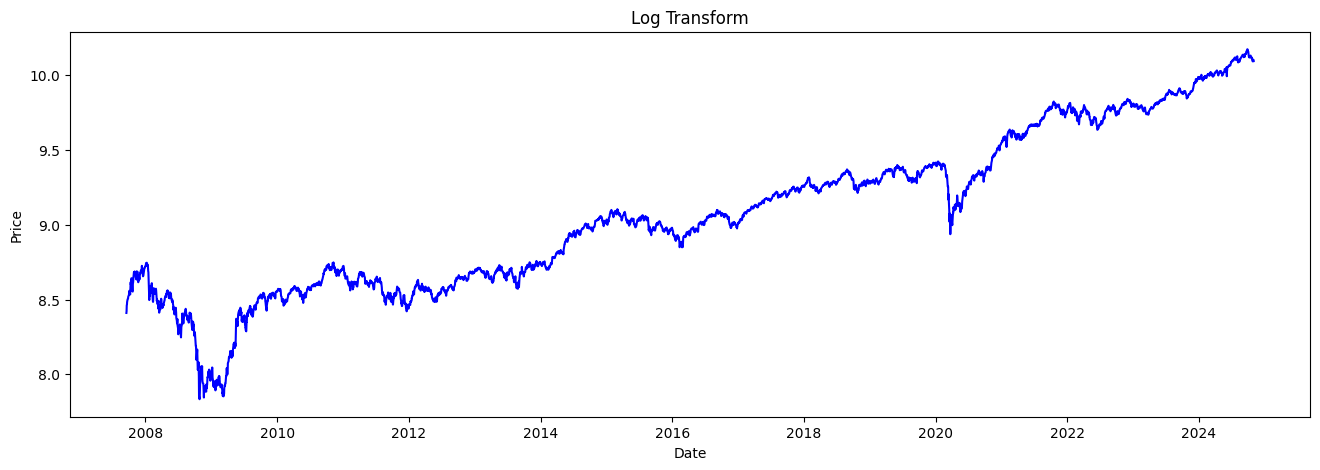

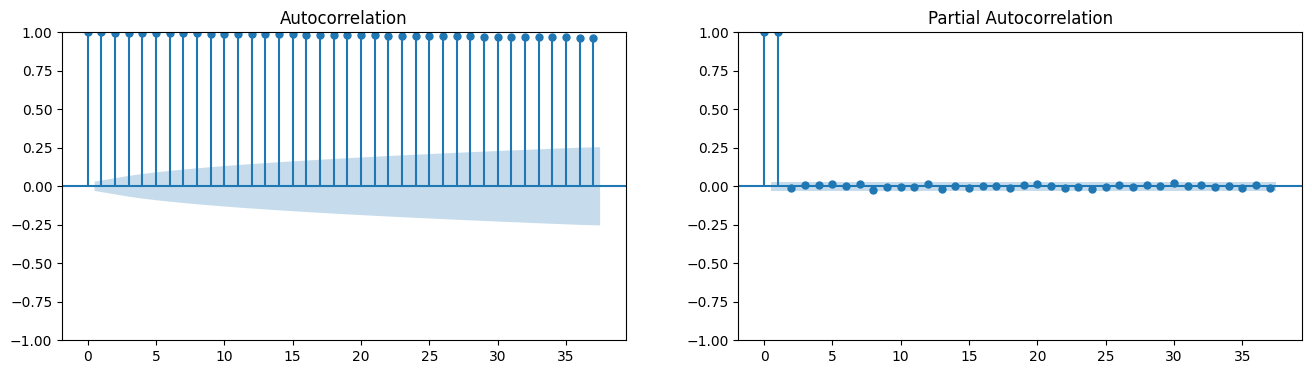

The series is stationary.
ADF Statistic: -11.966105
p-value: 0.000000


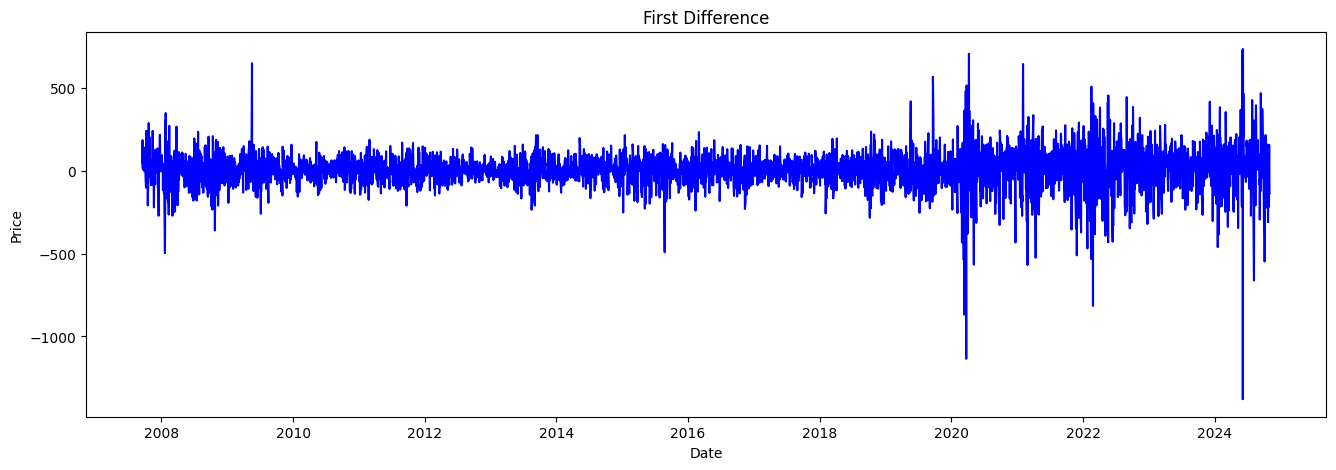

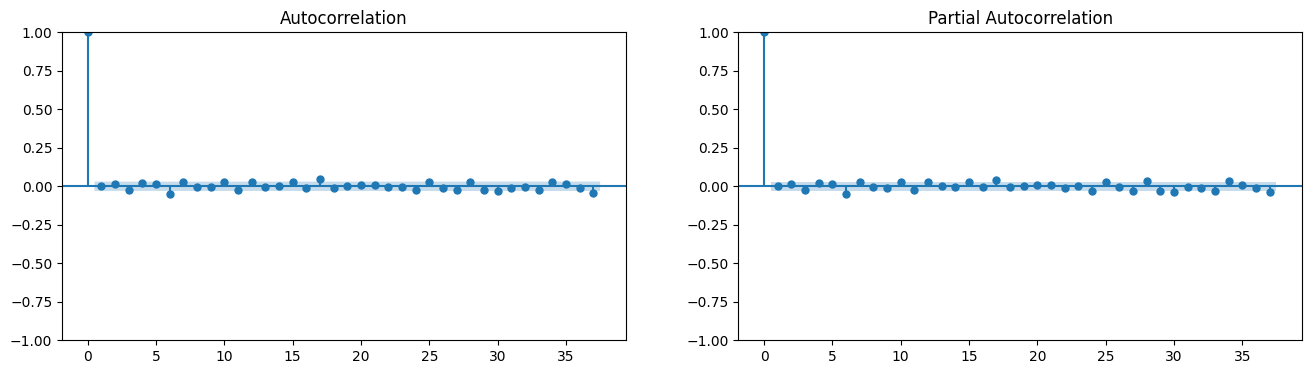

The series is stationary.
ADF Statistic: -14.369933
p-value: 0.000000


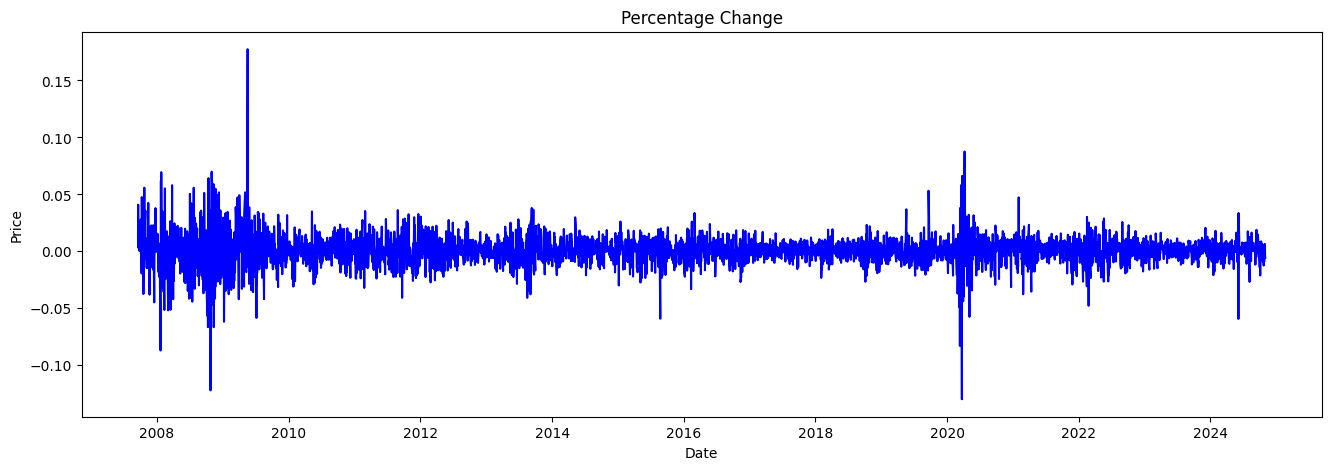

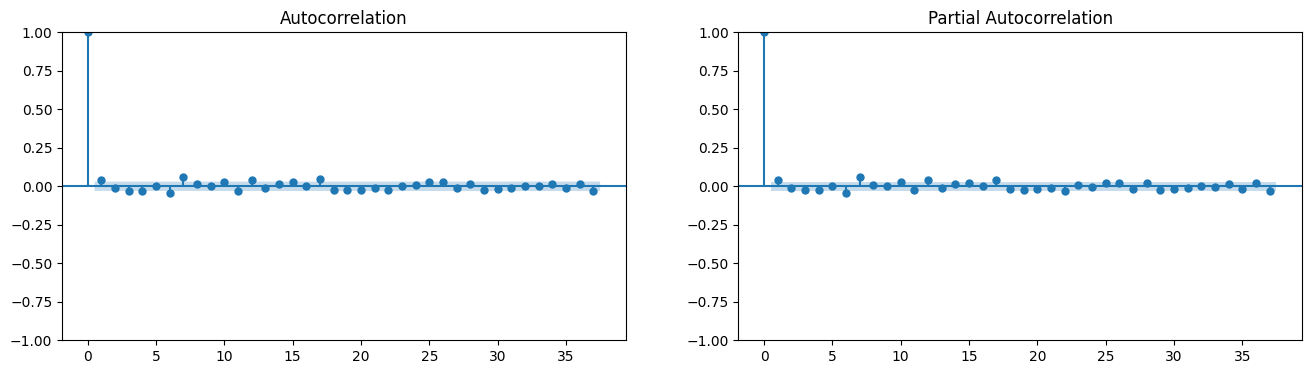

The series is stationary.
ADF Statistic: -10.796628
p-value: 0.000000


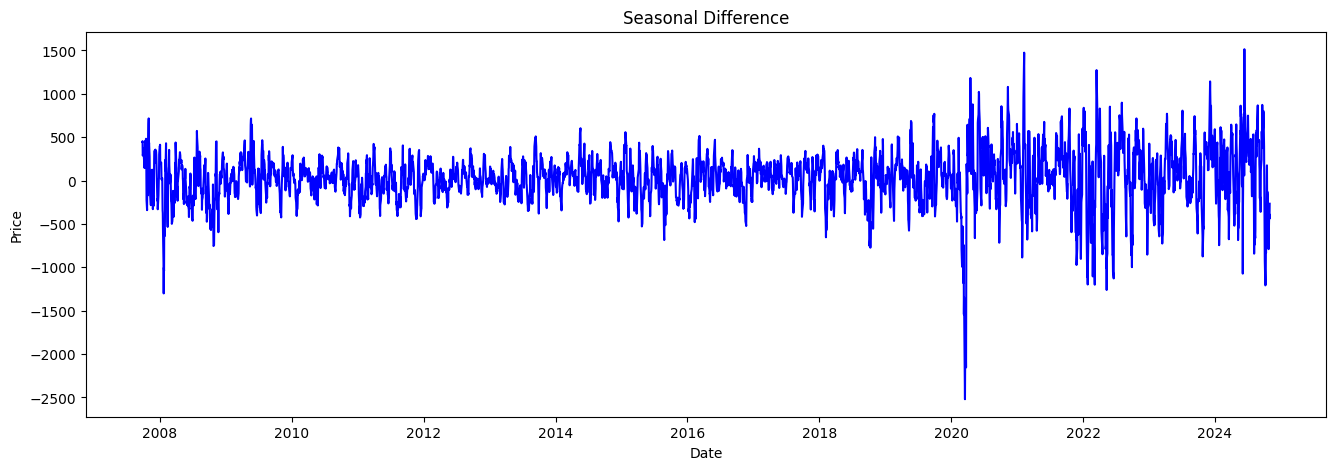

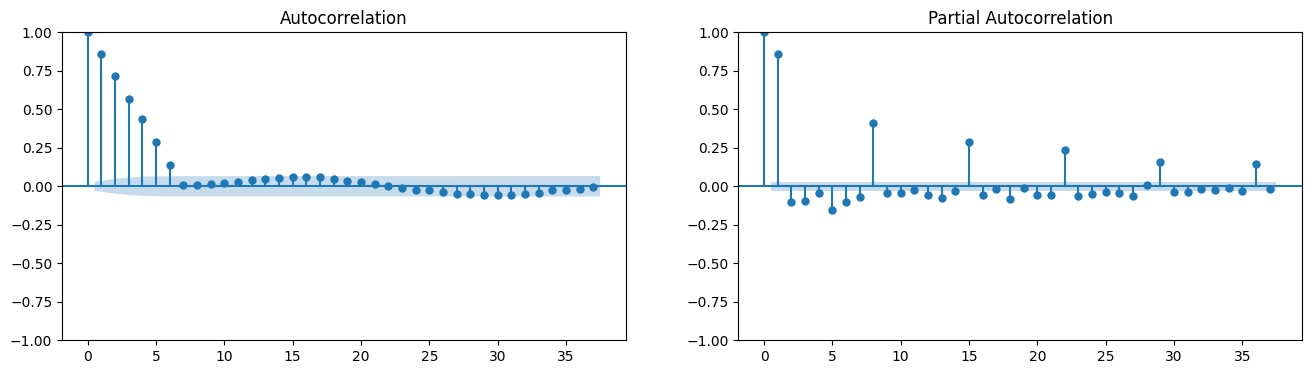

AttributeError: 'function' object has no attribute 'values'

In [100]:
transfor = Transformation(df['Close'])
log_data = transfor.log_transform()
first_diff = transfor.first_difference()
pct_change = transfor.pct_change()
seasonal_diff = transfor.seasonal_difference()
# boxcox = transfor.boxcox_transform()
data = [log_data, first_diff, pct_change, seasonal_diff, boxcox]
titles = ['Log Transform', 'First Difference', 'Percentage Change', 'Seasonal Difference', 'Box-Cox Transform']
for i, d in enumerate(data):
    Stationarity_Test(d)
    plot_df(d, title=titles[i])
    plot_acf_pacf(d)

In [101]:
seasonal_diff.head()


date
2007-09-26 00:00:00+00:00    445.850098
2007-09-27 00:00:00+00:00    454.349609
2007-09-28 00:00:00+00:00    289.000000
2007-10-01 00:00:00+00:00    321.400391
2007-10-03 00:00:00+00:00    373.250000
Name: Close, dtype: float64

In [106]:
seasonal_diff_inverse = transfor.seasonal_difference_inverse()
seasonal_diff_inverse.tail()

date
2024-10-25 00:00:00+00:00    24180.800781
2024-10-28 00:00:00+00:00    24339.150391
2024-10-29 00:00:00+00:00    24466.849609
2024-10-30 00:00:00+00:00    24340.849609
2024-10-31 00:00:00+00:00    24205.349609
Name: Close, dtype: float64

In [105]:
df['Close'].tail()

date
2024-10-25 00:00:00+00:00    24180.800781
2024-10-28 00:00:00+00:00    24339.150391
2024-10-29 00:00:00+00:00    24466.849609
2024-10-30 00:00:00+00:00    24340.849609
2024-10-31 00:00:00+00:00    24205.349609
Name: Close, dtype: float64

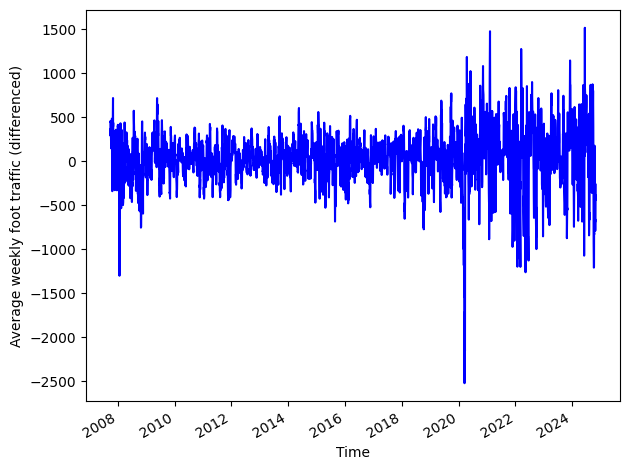

In [107]:
fig, ax = plt.subplots()

ax.plot(seasonal_diff, label='Seasonal Difference', color='blue')
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')

# plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F05_peixeiro.png', dpi=300)

In [108]:
ADF_result = adfuller(seasonal_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.796627799062756
p-value: 2.067602769945225e-19


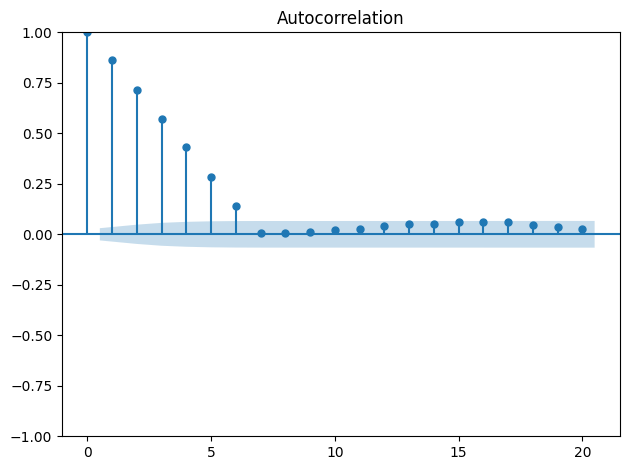

In [109]:
plot_acf(seasonal_diff, lags=20);

plt.tight_layout()

plt.savefig('figures/CH05_F06_peixeiro.png', dpi=300)

## Simulation 

In [9]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

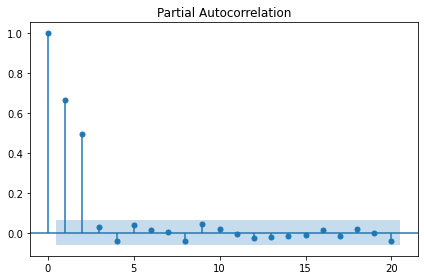

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20);

plt.tight_layout()

plt.savefig('figures/CH05_F07_peixeiro.png', dpi=300)

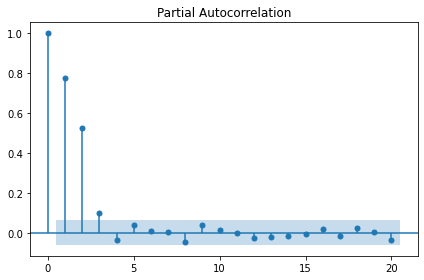

In [11]:
plot_pacf(foot_traffic_diff, lags=20);

plt.tight_layout()

plt.savefig('figures/CH05_F08_peixeiro.png', dpi=300)

In [110]:
df_diff = pd.DataFrame({'foot_traffic_diff': seasonal_diff})

train = df_diff[:-52]
test = df_diff[-52:]

print(len(train))
print(len(test))

4139
52


In [ ]:
test

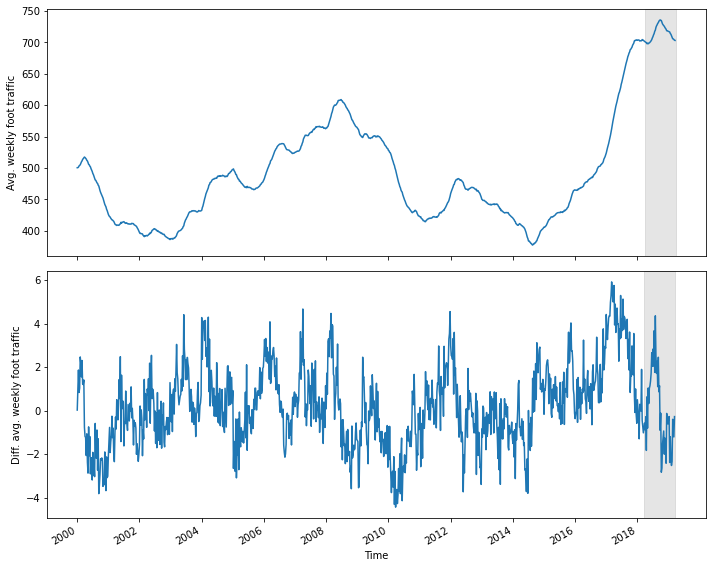

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['Close'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)

ax2.plot(seasonal_diff.values)
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F09_peixeiro.png', dpi=300)

In [119]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(5,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [120]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1
# convet the seasonal_diff to dataframe
seasonal_diff = pd.DataFrame(seasonal_diff)
pred_mean = rolling_forecast(seasonal_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(seasonal_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(seasonal_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
date,,,,
2024-08-20 00:00:00+00:00,581.849609,33.099469,275.150391,273.612212
2024-08-21 00:00:00+00:00,402.699219,33.232017,581.849609,600.833866
2024-08-22 00:00:00+00:00,464.500000,33.321239,402.699219,390.004114
2024-08-23 00:00:00+00:00,684.150391,33.425338,464.500000,335.367438
2024-08-26 00:00:00+00:00,866.849609,33.582404,684.150391,622.762918


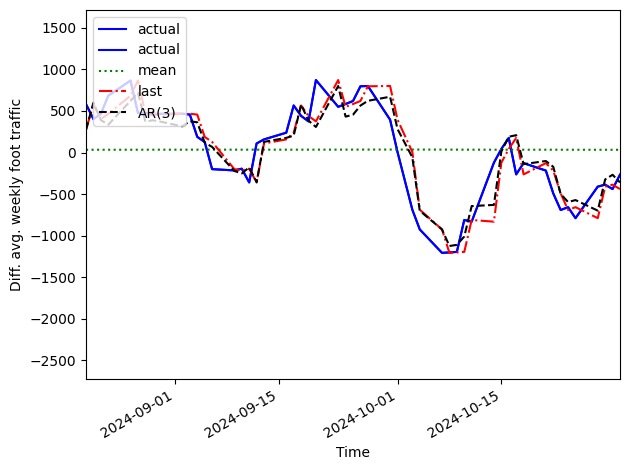

In [121]:
fig, ax = plt.subplots()

ax.plot(seasonal_diff['Close'], 'b-', label='actual')
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

# ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(seasonal_diff.index[TRAIN_LEN], seasonal_diff.index[TRAIN_LEN + HORIZON - 1])

# plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F10_peixeiro.png', dpi=300)

In [124]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

329646.9869070675 66975.57726133786 58596.660461519874


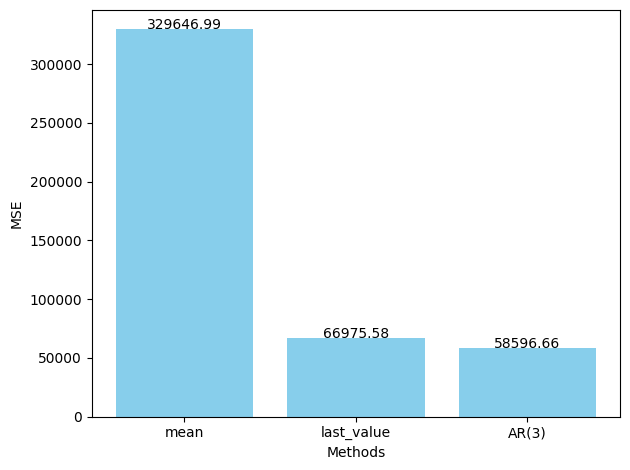

In [123]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, color='skyblue')
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
# ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [128]:
tras = Transformation(test['pred_AR'])
tras.seasonal_transformed_data = test['pred_AR']
pred_AR_inverse = tras.seasonal_difference_inverse()

In [132]:
pred_AR_inverse.info()
df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 52 entries, 2024-08-20 00:00:00+00:00 to 2024-10-31 00:00:00+00:00
Series name: pred_AR
Non-Null Count  Dtype  
--------------  -----  
52 non-null     float64
dtypes: float64(1)
memory usage: 832.0 bytes
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4198 entries, 2007-09-17 00:00:00+00:00 to 2024-10-31 00:00:00+00:00
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Close              4198 non-null   float64
 1   pred_foot_traffic  0 non-null      object 
dtypes: float64(1), object(1)
memory usage: 98.4+ KB


In [ ]:
TRAIN_LEN

4138

In [137]:
df['pred_foot_traffic'] = pd.Series()
df['pred_foot_traffic'][len(df)- HORIZON:] = df['Close'].iloc[len(df)- HORIZON] + pred_AR_inverse

In [ ]:
df

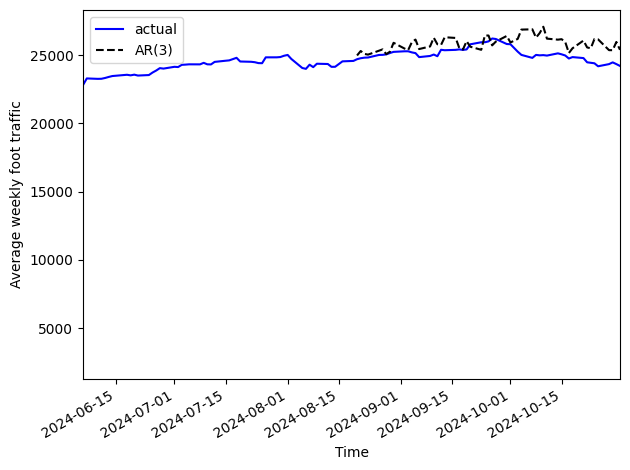

In [143]:
fig, ax = plt.subplots()

ax.plot(df['Close'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

# ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(df.index[-102],df.index[-1])
# ax.set_ylim(650, 770)

# plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F11_peixeiro.png', dpi=300)

In [145]:
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(df['Close'][-52:], df['pred_foot_traffic'][-52:])

print(mae_AR_undiff)

795.06009211301
